In [3]:
%pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.8 MB/s eta 0:00:00


In [29]:
# Import libraries
import re
import string
import nltk # type: ignore
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords # type: ignore
from nltk.stem import WordNetLemmatizer # type: ignore
from bs4 import BeautifulSoup # type: ignore
import contractions # type: ignore

import numpy as np # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore

from sklearn.tree import DecisionTreeClassifier # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.metrics import accuracy_score # type: ignore

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
# Load data
dataset_path = './IMDB-Dataset.csv'
df = pd.read_csv(dataset_path)

# Đếm số lượng các dòng trùng lặp (không tính hàng đầu tiên)
num_duplicates = df.duplicated().sum()

# Hiển thị số lượng mẫu trùng lặp
print(f"Số lượng sample trùng lặp: {num_duplicates}")

# Remove duplicate rows
df = df.drop_duplicates()
df.head()

Số lượng sample trùng lặp: 418


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [38]:
# Xoá thẻ html, xoá dấu câu, xoá số, xoá các icon,...
stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, 'html.parser')  # removing html tags

    text = soup.get_text()
    text = expand_contractions(text)  # expanding chatwords and contracts clearing contractions

    # Regex to remove emojis and icons (Modified)
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"           # other symbols
                             u"\U000024C2-\U0001F251"          # enclosed characters
                             "]+", flags=re.UNICODE)

    text = emoji_clean.sub(r'', text)  # removing emojis
    text = re.sub(r'\.(?=\S)', '. ', text)  # add space after full stop

    # Removing punctuation
    text = "".join([char for char in text if char not in string.punctuation])

    # Lemmatization and stopword removal
    text = " ".join([wl.lemmatize(word.lower()) for word in text.split() if word.lower() not in stop and word.isalpha()])

    return text

# Applying the function to a pandas DataFrame column
df['review'] = df['review'].apply(preprocess_text)

In [39]:
# Tạo tập hợp chứa các từ duy nhất (vocabulary) từ cột 'review' sau khi đã tiền xử lý
vocab = set()

# Thêm từ vào tập hợp vocab từ các review
df['review'].apply(lambda text: vocab.update(text.split()))

# Hiển thị kích thước của bộ từ điển
print(f"Kích thước bộ từ điển sau bước tiền xử lý: {len(vocab)}")

Kích thước bộ từ điển sau bước tiền xử lý: 143079


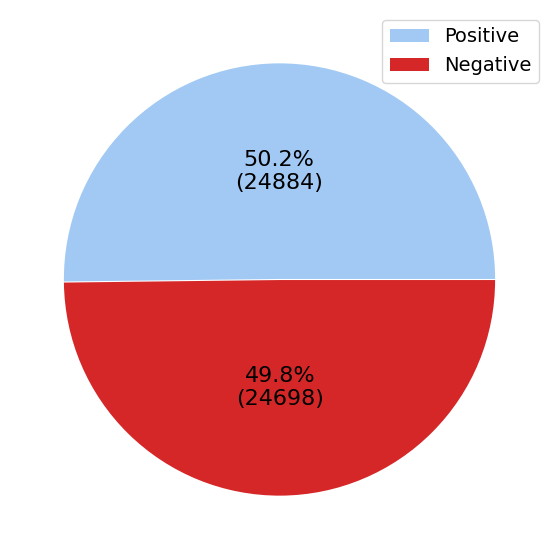

In [22]:
# Phân tích dữ liệu: Thống kê số lượng các nhãn trong bộ dữ liệu
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['Positive', 'Negative']

# Creating plot
#fig, ax = plt.subplots(figsize =(11, 7))

# Create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
pie = plt.pie(x=data,
              autopct = lambda pct: func(pct, data),
              explode=[0.0025]*2,
              pctdistance=0.5,
              colors=[sns.color_palette("pastel")[0], 'tab:red'],
              textprops={'fontsize': 16})

#plt.title('Frequencies of sentiment labels', fontsize=14, fontweight='bold')
labels = [r'Positive', r'Negative']
plt.legend(labels, loc='best', prop={'size': 14})
plt.savefig('PieChart.Png')
plt.show()

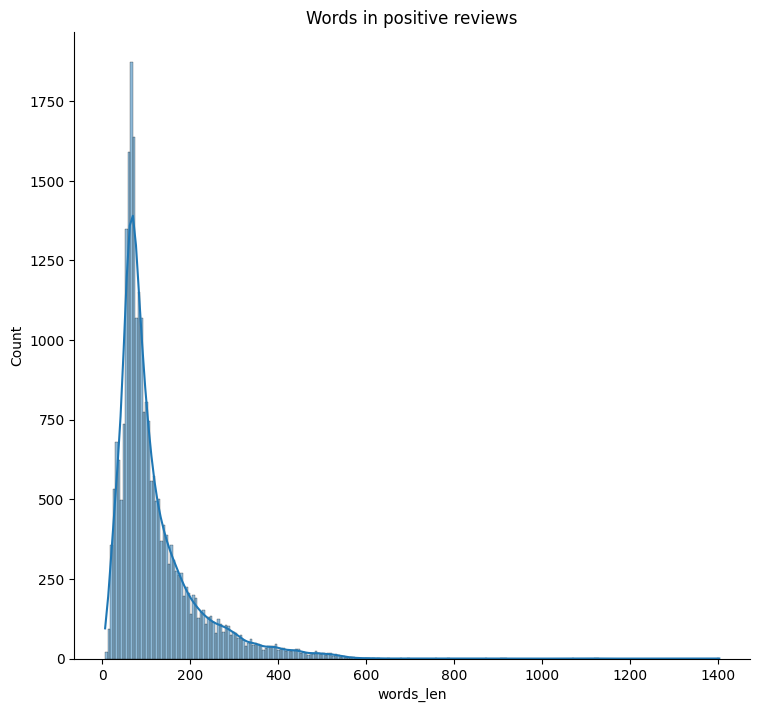

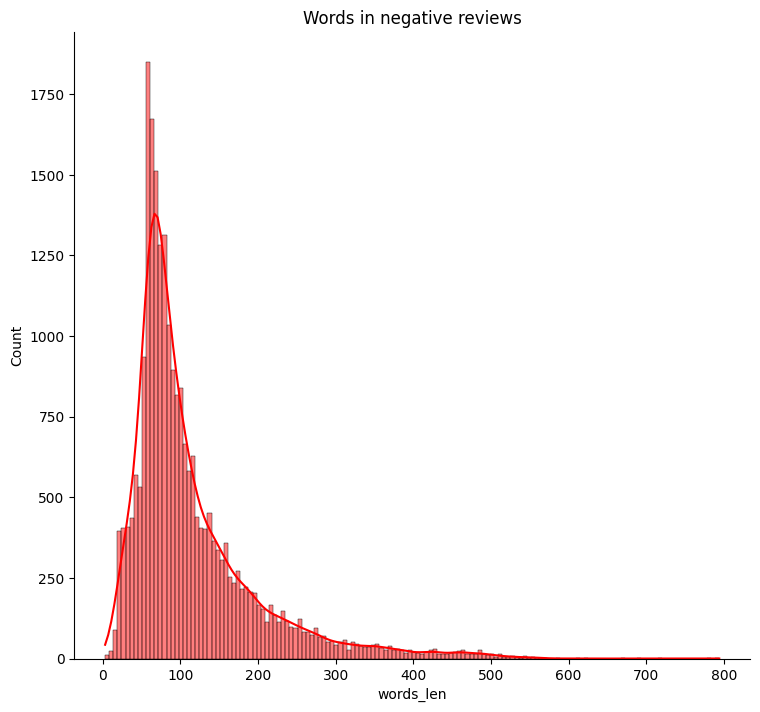

<ipython-input-25-14e12ddc15d2>:30: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  kernel_distibution_number_words_plot = sns.kdeplot(data=df_temp[df_temp['sentiment'] == 'positive'],


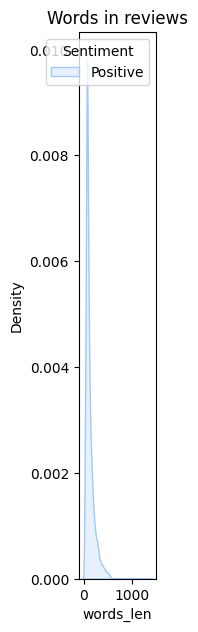

In [25]:

# Thống kê độ dài của các mẫu cho mỗi class
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words_len'] = words_len

hist_positive = sns.displot(data=df_temp[df_temp['sentiment'] == 'positive'],
                            x='words_len',
                            hue='sentiment',
                            kde=True,
                            height=7,
                            aspect=1.1,
                            legend=False
                            ).set(title='Words in positive reviews')

plt.show(hist_positive)

hist_negative = sns.displot(data=df_temp[df_temp['sentiment'] == 'negative'],
                            x='words_len',
                            hue='sentiment',
                            kde=True,
                            height=7,
                            aspect=1.1,
                            legend=False,
                            palette=['red']
                            ).set(title='Words in negative reviews')

plt.show(hist_negative)

plt.figure(figsize=(1, 7.1))
kernel_distibution_number_words_plot = sns.kdeplot(data=df_temp[df_temp['sentiment'] == 'positive'],
                                                   x='words_len',
                                                   hue='sentiment',
                                                   fill=True,
                                                   palette=[sns.color_palette("pastel")[0], 'red'],
                                                   ).set(title='Words in reviews')

plt.legend(title='Sentiment', labels=['Positive', 'Negative'])
plt.show(kernel_distibution_number_words_plot)

In [27]:
# Chia tập train và test

label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(df['review'], y_data, test_size=0.2, random_state=42)

In [31]:
# Biểu diễn văn bản thành vect
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

X_train_encoded = tfidf_vectorizer.fit_transform(X_train)
X_test_encoded = tfidf_vectorizer.transform(X_test)

In [33]:
# Huấn luyện và đánh giá mô hình
# Huấn luyện mô hình Decision Tree
df_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
df_classifier.fit(X_train_encoded, y_train)

y_pred = df_classifier.predict(X_test_encoded)

accuracy = accuracy_score(y_pred, y_test)

accuracy

0.719471614399516

In [34]:
# huấn luyện mô hình Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_encoded, y_train)

y_pred = rf_classifier.predict(X_test_encoded)

accuracy_rf = accuracy_score(y_pred, y_test)
accuracy_rf

0.841988504588081